In [1]:
import pickle
import glob
import pprint

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from typing import List
from collections import OrderedDict

# Helper functions

In [14]:
def get_batchsize(path: str) -> int:
    fname = path.split("/")[1]
    return int(fname.split("_")[4])


def get_ncpu(path: str) -> int:
    fname = path.split("/")[1]
    return int(fname.split("_")[2])


def unpack_data(ray_fnames: List[str], seq_fname: List[str], batch_sizes: List[int]):
    """
    Returns the data such that in each sublist the results are for a constant batch size and increasing number of cores.
    The first element of the list containts the timing results for the sequential run.
    """
    
    fname_lists = [[file for file in ray_fnames if get_batchsize(file) == size] for size in batch_sizes]
    fname_lists.insert(0, seq_fname)
    pprint.pprint(fname_lists)

    # Load data in memory
    experiments = []
    for lst in fname_lists:
        tmp = []
        for exp in lst:
            with open(exp, 'rb') as f:
                tmp.append(pickle.load(f))
        experiments.append(tmp)

    return experiments

def get_run_stats(run, field):
    data = run[field]
    avg = sum(data)/len(data)
    std = np.std(data)
    return avg, std

def extract_timeseries(experiments, field):
    means, stds = [], []
    for experiment in experiments:
        if experiment:
            tmp_mean, tmp_std = [], []
            for run in experiment:
                mu, sigma = get_run_stats(run, field)
                tmp_mean.append(mu)
                tmp_std.append(sigma)
            means.append(tmp_mean)
            stds.append(tmp_std)
        
    return means, stds

def get_data(experiments, max_ncpus, field='t_elapsed', decimals=3):
    
    means, stds = extract_timeseries(experiments, field)
    mean_arrays, std_arrays = [], []
    for mean_arr, std_arr in zip(means, stds):
        if len(mean_arr) == 1:
            mean_arrays.append(np.around(np.array(mean_arr*max_ncpus), decimals=decimals)) 
            std_arrays.append(np.around(np.array(std_arr*max_ncpus), decimals=decimals))
        elif len(mean_arr) in range(2, max_ncpus):
            mean_arrays.append(np.around(np.array([0]*(max_ncpus - len(mean_arr)) + mean_arr), 
                                         decimals=decimals))
            std_arrays.append(np.around(np.array([0]*(max_ncpus - len(mean_arr)) + std_arr),
                                       decimals=decimals))
    return mean_arrays, std_arrays


def compare_timing(means, stds, labels, max_ncpus, bar_width = 0.1, y_min=0, y_max=34.0, y_step = 0.5,
                   legend_pos=(1.24, -0.09), yticks_fontsize=20):
    
    
    fig, ax = plt.subplots(figsize=(40, 20))
    bar_positions = np.array(np.arange(1, max_ncpus))
    xticks = [str(x) for x in range(1, max_ncpus + 1)]
    bps = []
    with sns.axes_style("white"):
        sns.set_style("ticks")
        sns.set_context("talk")
        for m, s, label in zip(means, stds, labels):
            bar_plot = ax.bar(bar_positions,
                              m,
                              bar_width,
                              yerr=s,
                              label=label,
                              capsize=10
                              )
            bps.append(bar_plot)
            bar_positions = bar_positions + bar_width

        ax.set_xlabel(r'ncpu', fontsize=30)
        ax.set_xticks(bar_positions - 2*bar_width)
        ax.set_xticklabels(xticks, rotation=45, fontsize=25)

        ax.set_ylabel('Time (s)', fontsize=30)
        ax.set_ylim(top=y_max)
        ax.set_ylim(bottom=y_min)
        y_ticks = np.arange(y_min, y_max, y_step)
        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_ticks, fontsize=yticks_fontsize)
        
        ax.grid(True)
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = OrderedDict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), ncol=2, fontsize=20)
        sns.despine()
    
    return ax, bps

def autolabel(ax, rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=20)

In [18]:
actor_fraction = 0.33
ray_files = glob.glob(f'results/ray_*{actor_fraction}.pkl')
sequential_file = glob.glob('results/sequential.pkl')
batch_sizes = [10, 20, 40, 80]
max_ncpus = 3


In [16]:
experiments = unpack_data(ray_files, sequential_file, batch_sizes)
mean, std = get_data(experiments, max_ncpus)

[['results/sequential.pkl'],
 ['results/ray_ncpu_2_bsize_10_actorfr_0.5.pkl',
  'results/ray_ncpu_3_bsize_10_actorfr_0.5.pkl'],
 ['results/ray_ncpu_2_bsize_20_actorfr_0.5.pkl',
  'results/ray_ncpu_3_bsize_20_actorfr_0.5.pkl'],
 ['results/ray_ncpu_2_bsize_40_actorfr_0.5.pkl',
  'results/ray_ncpu_3_bsize_40_actorfr_0.5.pkl'],
 ['results/ray_ncpu_2_bsize_80_actorfr_0.5.pkl',
  'results/ray_ncpu_3_bsize_80_actorfr_0.5.pkl']]


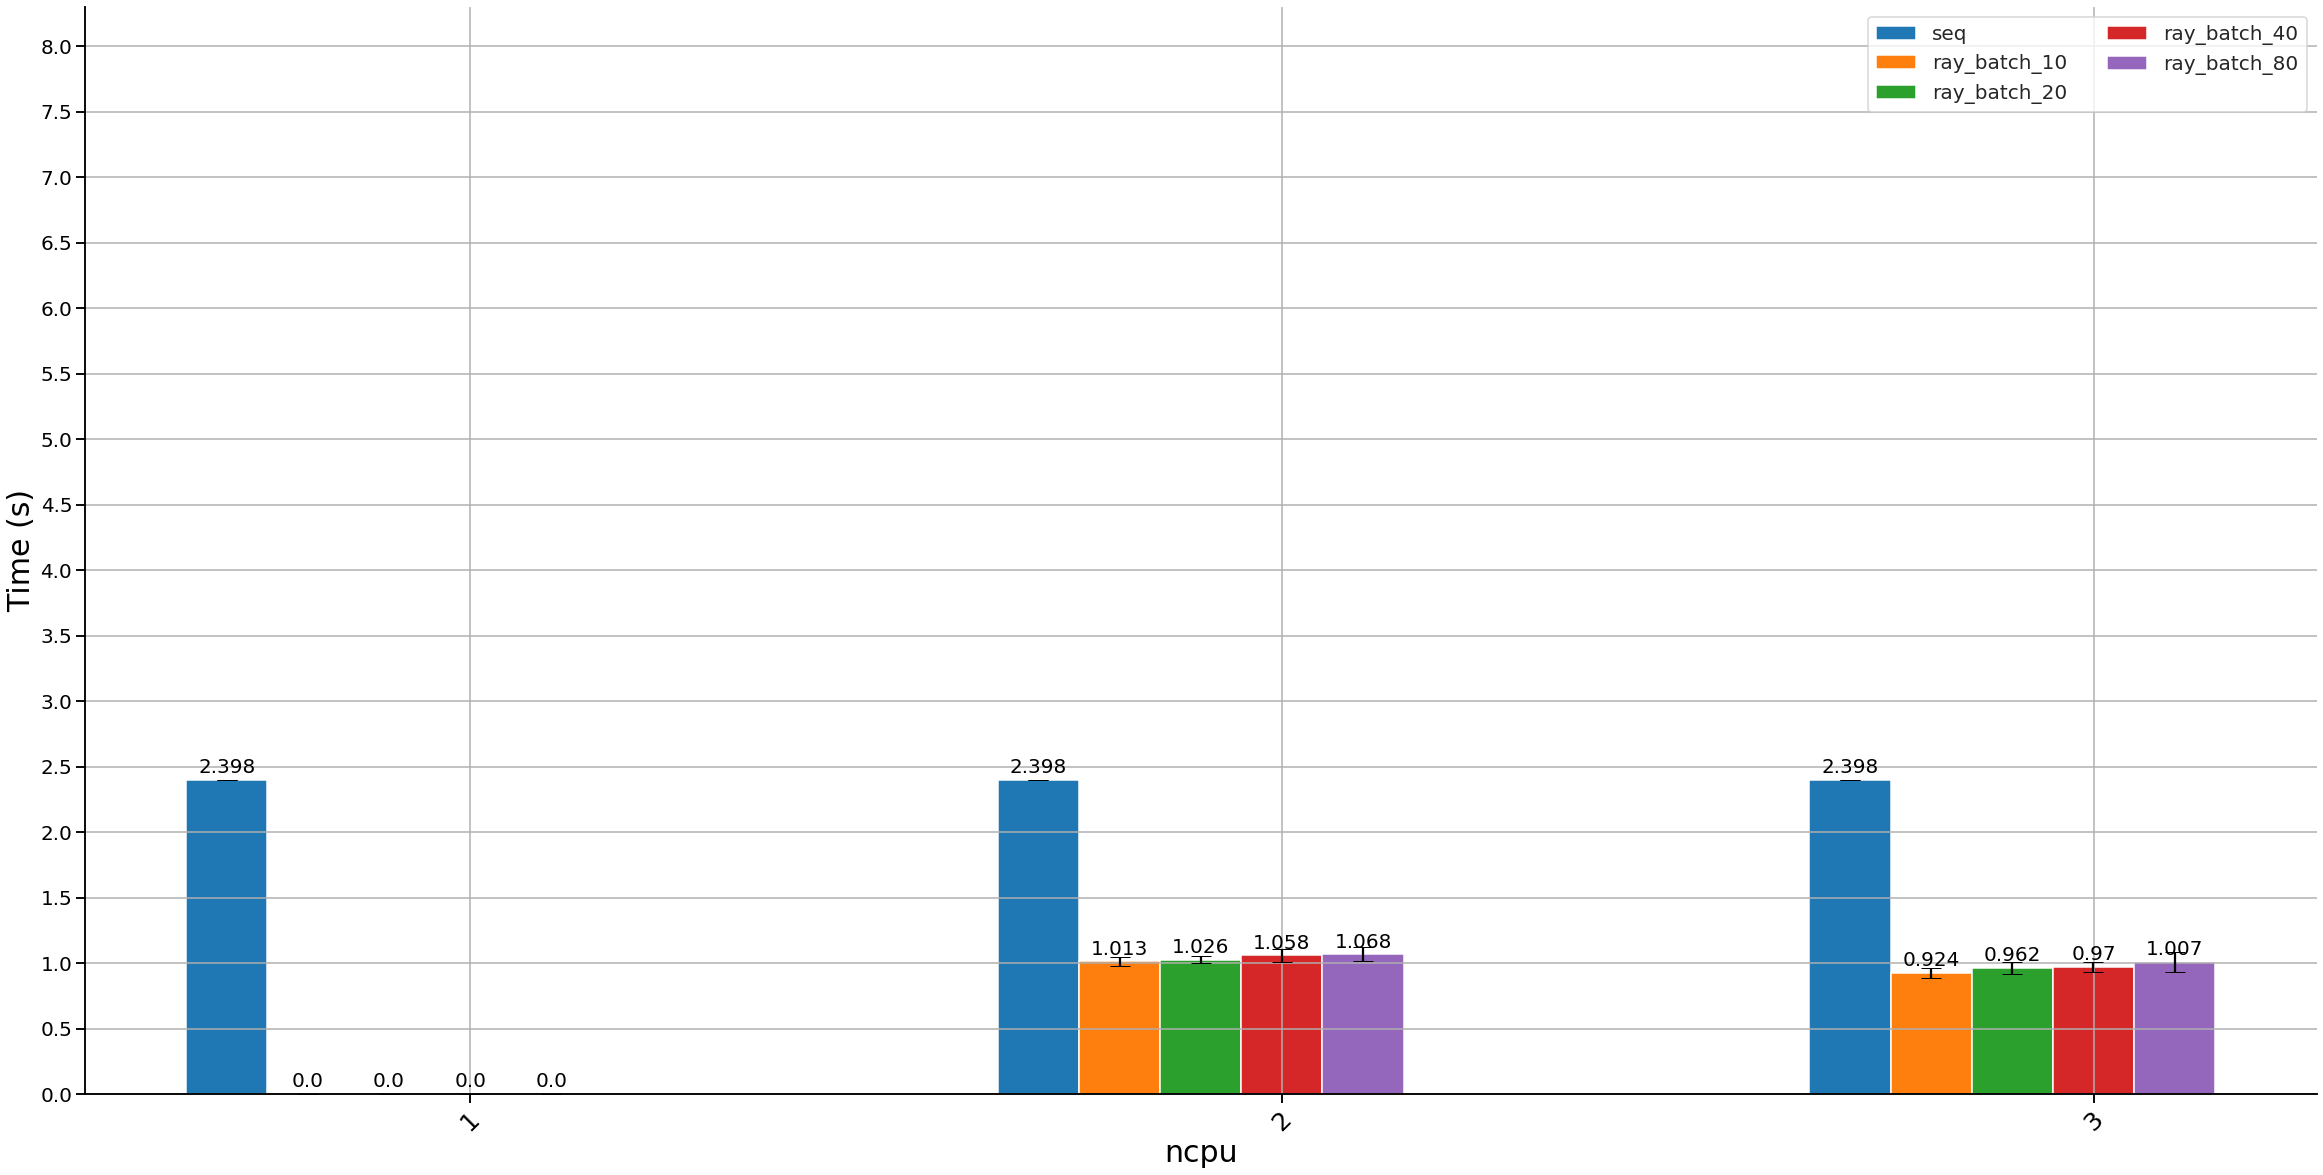

In [10]:
labels = ['seq'] + ['ray_batch_{}'.format(size) for size in batch_sizes]
ax, bps = compare_timing(mean, std, labels, 4, y_max=8.3, y_step=0.5)

for bp in bps:
    autolabel(ax, bp)

plt.show()

# initial attempt with 0.5

## Sanity checks

In [23]:
with open('results/ray_ncpu_2_bsize_40_actorfr_0.2.pkl', 'rb') as f:
    times = pickle.load(f)['t_elapsed']
print(np.mean(times))

5.210521050000352
